In [1]:
import os
import gc
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [2]:

n_folds = 5
feature_size_bowel = 128+1
#feature_size_lsk = 1408+1
feature_size_lsk=128+1

len_seq_bowl = 128 # all abdomen
len_seq_lsk = 24 # liver/spleen/kidney
#lstm_size=256
lstm_size=129


init_lr = 5e-4

eta_min = 0
batch_size = 64
drop_rate = 0.
drop_rate_last = 0.5
#drop_path_rate = 0.3
p_mixup = 0.0 #0 0.3
p_rand_order_v1 = 0.0 # 0.2
p_rand_series = 0.0

data_dir_bowel = './features2b'
data_dir_lsk = './features2lstm_feat2/'
num_workers = 6

n_epochs = 30

log_dir = './logs'
model_dir = './models_stage3_all'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# DataFrame

In [3]:
from sklearn.model_selection import KFold

organ_dict = {
    0: "liver",
    1: "spleen",
    2: 'kidney',
    3: "bowel", 
    4: 'extravasation'
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')

#df_p=df_p.head(256) # debug


df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold



df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
fold = []
hu=[]
counts=[]
lbowel=[]
lliver=[]
lspleen=[]
lkidney=[]
lextra=[]
lany=[]
for row in df.to_dict(orient="records"):
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        hu.append(row["aortic_hu"])
        lab_bowel=row["bowel_injury"]
        lab_extravasation=row["extravasation_injury"]
        lab_liver=np.argmax([row["liver_healthy"],row["liver_low"],row["liver_high"]])
        lab_spleen=np.argmax([row["spleen_healthy"],row["spleen_low"],row["spleen_high"]])
        lab_kidney=np.argmax([row["kidney_healthy"],row["kidney_low"],row["kidney_high"]])
        lab_any_injury=row["any_injury"]

        la=[lab_liver,lab_spleen,lab_kidney,lab_bowel,lab_extravasation]
        label.append(la)
        lliver.append(lab_liver)
        lspleen.append(lab_spleen)
        lkidney.append(lab_kidney)
        lbowel.append(lab_bowel)
        lextra.append(lab_extravasation)
        lany.append(lab_any_injury)
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'hu':hu,
    'label': label,
    "liver":lliver,
    "spleen":lspleen,
    "kidney":lkidney,
    'bowel':lbowel,
    "extravasation":lextra,
    "any_injury":lany,
    'fold': fold,
    'counts':counts,
})
df.set_index(['patient_id', 'series_id'], inplace=True,drop=False)
df.index.names=["pid","sid"]
df.sort_values(by=["patient_id","hu"],inplace=True)



In [4]:

df


patient_id  series_id      hu            label  liver  spleen  \
pid   sid                                                                    
19    14374          19      14374  174.00  [0, 0, 0, 0, 0]      0       0   
26    41997          26      41997  101.00  [0, 0, 0, 0, 0]      0       0   
      18881          26      18881  255.00  [0, 0, 0, 0, 0]      0       0   
33    55570          33      55570  105.00  [1, 0, 0, 1, 1]      1       0   
43    36714          43      36714   54.75  [0, 0, 0, 1, 1]      0       0   
...                 ...        ...     ...              ...    ...     ...   
65456 40781       65456      40781  162.00  [0, 2, 0, 1, 0]      0       2   
65495 8371        65495       8371  248.00  [0, 0, 0, 0, 0]      0       0   
65504 55928       65504      55928  144.00  [1, 2, 0, 0, 0]      1       2   
      50212       65504      50212  276.00  [1, 2, 0, 0, 0]      1       2   
65508 34551       65508      34551  153.00  [0, 0, 0, 0, 0]      0       0   

             kidney  bowel  extravasation  any_injury  fold  counts  
pid   sid                                                            
19    14374       0      0              0           0     3       1  
26    41997       0      0              0           0     2       2  
      18881       0      0              0           0     2       2  
33    55570       0      1              1           1     1       1  
43    36714       0      1              1           1     1       2  
...             ...    ...            ...         ...   ...     ...  
65456 40781       0      1              0           1     2       1  
65495 8371        0      0              0           0     1       1  
65504 55928       0      0              0           1     2       2  
      50212       0      0              0           1     2       2  
65508 34551       0      0              0           0     0       1  

[4711 rows x 12 columns]

# Dataset

In [5]:
def slice_permute(x): #(T,K)
    n=x.shape[0]
    indices1 = torch.randperm(n//2)
    indices2 = torch.randperm(n//2)+n//2
    indices=torch.concat((indices1,indices2))
    return x[indices]

def series_exchange(x): #(T,K)
    n=x.shape[0]
    indices1 = torch.arange(0,n//2)
    indices2 = torch.arange(n//2,n)
    indices=torch.concat((indices2,indices1))
    return x[indices]
    


In [6]:
class CLS3Dataset(Dataset):
    def __init__(self, df, mode, fold):

        self.df = df
        self.mode = mode
        self.fold=fold

    def __len__(self):
        return self.df.patient_id.nunique()

    def __getitem__(self, index):
        rows= self.df.loc[[self.df.index.unique(level=0)[index]]] # unique patient, may have up to two series (rows)

        
        data_bowel=[]
        data_liver=[]
        data_spleen=[]
        data_kidney=[]
        data_hu=[]
        for i in range(len(rows)):
            row=rows.iloc[i]
            filepath_bowel=os.path.join(data_dir_bowel, f'model{self.fold}/{row.patient_id}_{row.series_id}.npy')
            filepath_liver=os.path.join(data_dir_lsk, f'model{self.fold}/{row.patient_id}_{row.series_id}_0.npy')
            filepath_spleen=os.path.join(data_dir_lsk, f'model{self.fold}/{row.patient_id}_{row.series_id}_1.npy')
            filepath_kidney=os.path.join(data_dir_lsk, f'model{self.fold}/{row.patient_id}_{row.series_id}_2.npy')

            dbowel=np.load(filepath_bowel)
            dliver=np.load(filepath_liver)
            dspleen=np.load(filepath_spleen)
            dkidney=np.load(filepath_kidney)
            
            dbowel=np.concatenate((dbowel,np.array(len_seq_bowl*[row.hu])[:,None]),axis=1)
            dliver=np.concatenate((dliver,np.array(len_seq_lsk*[row.hu])[:,None]),axis=1)
            dspleen=np.concatenate((dspleen,np.array(len_seq_lsk*[row.hu])[:,None]),axis=1)
            dkidney=np.concatenate((dkidney,np.array(len_seq_lsk*[row.hu])[:,None]),axis=1)

            data_bowel.append(dbowel)
            data_liver.append(dliver)
            data_spleen.append(dspleen)
            data_kidney.append(dkidney)
            data_hu.append((row.hu,))
            
        if len(rows)==1:
            data_bowel.append(np.zeros((len_seq_bowl,feature_size_bowel)))
            data_liver.append(np.zeros((len_seq_lsk,feature_size_lsk)))
            data_spleen.append(np.zeros((len_seq_lsk,feature_size_lsk)))
            data_kidney.append(np.zeros((len_seq_lsk,feature_size_lsk)))
            data_hu.append((-1,))

        data_bowel=np.concatenate(data_bowel,axis=0)
        data_liver=np.concatenate(data_liver,axis=0)
        data_spleen=np.concatenate(data_spleen,axis=0)
        data_kidney=np.concatenate(data_kidney,axis=0)
        data_hu=np.stack(data_hu)
        data_bowel = torch.tensor(data_bowel).float()
        data_liver = torch.tensor(data_liver).float()
        data_spleen = torch.tensor(data_spleen).float()
        data_kidney = torch.tensor(data_kidney).float()
        data_hu = torch.tensor(data_hu).float()
       
     
            
        if self.mode == 'train' :
            for x in [data_bowel,data_liver,data_spleen,data_kidney]:
                if random.random() < p_rand_order_v1:
                    x[...]=slice_permute(x)
            if random.random()<p_rand_series:
                for x in [data_bowel,data_liver,data_spleen,data_kidney,data_hu]:
                    x[...]=series_exchange(x)
                
        data={"bowel":data_bowel,"liver":data_liver,"spleen":data_spleen,"kidney":data_kidney,"hu":data_hu}        
        
        if self.mode != 'test':
            labels={"liver":row.liver,"spleen":row.spleen,"kidney":row.kidney,"bowel":row.bowel,"extravasation":row.extravasation,"any_injury":row.any_injury}
            labels={k:torch.tensor(labels[k]).float() for k in labels}
           
            return data, labels
        else:
            return data

In [7]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLS3Dataset(df_show, 'train', fold=0)
print(len(df),len(dataset_show))
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)

4711 3147


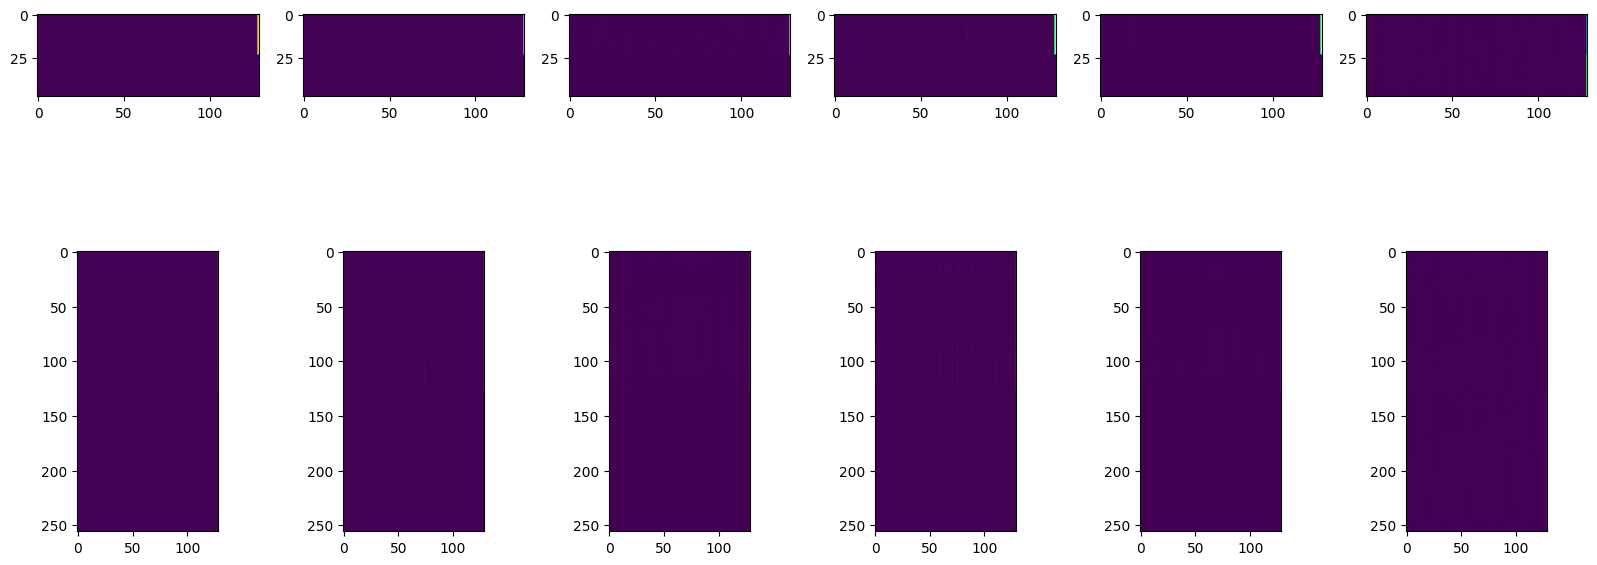

In [8]:
f, axarr = plt.subplots(2,6)
for p in range(6):
    idx = p * 20
    data, lbl = dataset_show[idx]
    axarr[0,p].imshow(data["liver"])
    axarr[1,p].imshow(data["bowel"])

In [9]:
batch=next(iter(loader_show)) 
print(batch[1]["any_injury"])

tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


# Attention

In [10]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)


In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.weight = 0
        self.count=0
    def update(self, vals, w=1):
        self.val = vals
        self.count += len(vals)
        self.sum += np.sum(vals * w)
        self.weight += np.sum(w)
        self.avg = self.sum / self.weight

In [12]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, data):
        for k in data:
            x=data[k]
            x = x.unsqueeze(2)    # (N, T, 1, K)
            x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
            x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
            x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
            x = x.squeeze(2)  # (N, T, K)
            data[k]=x
        return data


# Model

In [13]:
class PENet(nn.Module):
    def __init__(self, feature_size_bowel,feature_size_lsk,lstm_size):
        super().__init__()
        self.feature_size_bowel=feature_size_bowel
        self.feature_size_lsk=feature_size_lsk
        lstm_size2=lstm_size
        att_size=lstm_size
        final_size_liver=2*att_size
        final_size_bowel=64
#

        #self.lstm_bowel = nn.GRU(feature_size_bowel, lstm_size2, bidirectional=True, batch_first=True,num_layers=1)
        self.lstm_liver = nn.GRU(feature_size_lsk, lstm_size, bidirectional=True, batch_first=True,num_layers=1)
        #self.lstm_spleen = nn.GRU(feature_size_lsk, lstm_size, bidirectional=True, batch_first=True)
        self.lstm_spleen=self.lstm_liver
        #self.lstm_kidney = nn.GRU(feature_size_lsk, lstm_size, bidirectional=True, batch_first=True)
        self.lstm_kidney=self.lstm_liver
      
        self.attention_bowel = Attention(att_size, len_seq_bowl*2)
        self.attention_liver = Attention(att_size, len_seq_lsk*2)
        #self.attention_spleen = Attention(lstm_size*2, len_seq_lsk*2)
        #self.attention_kidney = Attention(lstm_size*2, len_seq_lsk*2)
        #self.attention_liver=self.attention_bowel
        self.attention_spleen=self.attention_liver
        self.attention_kidney=self.attention_liver
         

        self.top_liver = nn.Sequential(
            nn.Linear(2*att_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1))
        
        self.top_bowel = nn.Sequential(
            nn.Linear(2*att_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1))


        self.last_linear_liver = nn.Linear(final_size_liver, 3)
        #self.last_linear_spleen = nn.Linear(lstm_size*4, 3)
        #self.last_linear_kidney = nn.Linear(lstm_size*4, 3)
        self.last_linear_spleen=self.last_linear_liver
        self.last_linear_kidney=self.last_linear_liver

        self.last_linear_bowel = nn.Linear(final_size_bowel, 1)
        self.last_linear_extravasation = nn.Linear(final_size_bowel, 1)
        self.drop=nn.Dropout(p=drop_rate_last)


    def forward(self, x,mask=None):  # (bs, nslice, ch)
        #x = SpatialDropout(0.5)(x)

        #h_lstm_bowel, _ = self.lstm_bowel(x["bowel"])
        h_lstm_bowel  = x["bowel"]

        max_pool_bowel, _ = torch.max(h_lstm_bowel, 1)

        att_pool_bowel = self.attention_bowel(h_lstm_bowel, mask=None)
        
        #h_lstm_liver, _ = self.lstm_liver(x["liver"])
        h_lstm_liver  = x["liver"]

        max_pool_liver, _ = torch.max(h_lstm_liver, 1)
        att_pool_liver = self.attention_liver(h_lstm_liver, mask=None)
        
        #h_lstm_spleen, _ = self.lstm_spleen(x["spleen"])
        h_lstm_spleen = x["spleen"]
        max_pool_spleen, _ = torch.max(h_lstm_spleen, 1)
        att_pool_spleen = self.attention_spleen(h_lstm_spleen, mask=None)
         
        #h_lstm_kidney, _ = self.lstm_kidney(x["kidney"])
        h_lstm_kidney = x["kidney"]

        max_pool_kidney, _ = torch.max(h_lstm_kidney, 1)
        att_pool_kidney = self.attention_kidney(h_lstm_kidney, mask=None)

        
        conc_bowel = torch.cat((max_pool_bowel, att_pool_bowel), 1)   #N,F
        conc_liver = torch.cat((max_pool_liver, att_pool_liver), 1) 
        conc_spleen = torch.cat((max_pool_spleen, att_pool_spleen), 1) 
        conc_kidney = torch.cat((max_pool_kidney, att_pool_kidney), 1) 
        conc_all=torch.cat((conc_bowel,conc_liver,conc_spleen,conc_kidney),1)

        
        #conc_liver=self.top_liver(conc_liver)
        #conc_spleen=self.top_liver(conc_spleen)
        #conc_kidney=self.top_liver(conc_kidney)

        conc_bowel=self.top_bowel(conc_bowel)

        logits_liver = self.last_linear_liver(conc_liver)
        logits_spleen = self.last_linear_spleen(conc_spleen)
        logit_kidney = self.last_linear_kidney(conc_kidney)

        logits_bowel = self.last_linear_bowel(conc_bowel)
        logits_extravasation = self.last_linear_extravasation(conc_bowel)


        logits_bowel=logits_bowel.squeeze()
        logits_extravasation=logits_extravasation.squeeze()
        logits={"liver":logits_liver,"spleen":logits_spleen,"kidney":logit_kidney,"bowel":logits_bowel,"extravasation":logits_extravasation}
        return logits

In [14]:
from torchinfo import summary
model = PENet(feature_size_bowel, feature_size_lsk,lstm_size=lstm_size)
model = model.cuda()
#mask = np.zeros((len_seq_bowl,), dtype=np.float32)
#print(summary(model,input_size=(batch_size,2*len_seq_bowl,feature_size_bowel)))
print(summary(model))


Layer (type:depth-idx)                   Param #
PENet                                    --
├─GRU: 1-1                               201,240
├─GRU: 1-2                               (recursive)
├─GRU: 1-3                               (recursive)
├─Attention: 1-4                         385
├─Attention: 1-5                         177
├─Attention: 1-6                         (recursive)
├─Attention: 1-7                         (recursive)
├─Sequential: 1-8                        --
│    └─Linear: 2-1                       16,576
│    └─BatchNorm1d: 2-2                  128
│    └─Dropout: 2-3                      --
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-9                        --
│    └─Linear: 2-5                       16,576
│    └─BatchNorm1d: 2-6                  128
│    └─Dropout: 2-7                      --
│    └─LeakyReLU: 2-8                    --
├─Linear: 1-10                           777
├─Linear: 1-11                           (recursive)
├─Linear

# Scoring

In [15]:
import sklearn

class ParticipantVisibleError(Exception):
    pass

def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    # Run basic QC checks on the inputs
    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution.min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = ['bowel', 'extravasation']
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']

        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise ParticipantVisibleError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )

    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    all_target_categories.append("any_injury")
    
    group_losses={all_target_categories[i]:label_group_losses[i] for i in range(len(all_target_categories)) }
    return np.mean(label_group_losses),group_losses


In [16]:
# Assign the appropriate weights to each category
def create_training_solution(y_train):
    sol_train = y_train.copy()
    
    # bowel healthy|injury sample weight = 1|2
    sol_train['bowel_weight'] = np.where(sol_train['bowel_injury'] == 1, 2, 1)
    
    # extravasation healthy/injury sample weight = 1|6
    sol_train['extravasation_weight'] = np.where(sol_train['extravasation_injury'] == 1, 6, 1)
    
    # kidney healthy|low|high sample weight = 1|2|4
    sol_train['kidney_weight'] = np.where(sol_train['kidney_low'] == 1, 2, np.where(sol_train['kidney_high'] == 1, 4, 1))
    
    # liver healthy|low|high sample weight = 1|2|4
    sol_train['liver_weight'] = np.where(sol_train['liver_low'] == 1, 2, np.where(sol_train['liver_high'] == 1, 4, 1))
    
    # spleen healthy|low|high sample weight = 1|2|4
    sol_train['spleen_weight'] = np.where(sol_train['spleen_low'] == 1, 2, np.where(sol_train['spleen_high'] == 1, 4, 1))
    
    # any healthy|injury sample weight = 1|6
    sol_train['any_injury_weight'] = np.where(sol_train['any_injury'] == 1, 6, 1)
    return sol_train


In [17]:
criterion = nn.CrossEntropyLoss(reduction='none').cuda()
criterion2 = nn.BCEWithLogitsLoss(reduction='none').cuda()
criterion2a=nn.BCELoss(reduction="none").cuda()

# Mixup

In [18]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(data1,targets1):
    batch_size = data1["liver"].shape[0]
    data2={}
    targets2={}
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    for key in data1:      
        x1=data1[key]
        x2=x1[idx,...]
        xmix = x1 * x_l + x2 * (1 - x_l)
        data2[key]=xmix

    for key in targets1:
        y1=targets1[key]
        y_l=l
        y2=y1[idx]
        if y1.dim()==1:
            y_l=y_l.squeeze()

        ymix = y1 * y_l + y2 * (1 - y_l)
        targets2[key]=ymix
        assert targets2[key].shape==targets1[key].shape
    
    return (data2, targets2)

# Train/Valid funuctions

In [19]:



def train_func(model, loader_train, optimizer, scaler,total_weight,debug=False):
    model.train()
    train_loss = [] 
    group_loss={k:[] for k in ["liver","spleen","kidney","bowel","extravasation","any_injury"]}
    bar = tqdm(loader_train)
    for data, targets  in bar:
        optimizer.zero_grad()
        data = {k:data[k].cuda() for k in data}
        targets = {k: targets[k].cuda() for k in targets}
        for k in ["liver","spleen","kidney"]:
            targets[k]=F.one_hot(targets[k].long(), num_classes= 3).float()
            
  
        if random.random() < p_mixup:
            data, targets = mix_up(data, targets)
      
        with amp.autocast():

            logits=model(data)
            dloss={}
            prob_injury={}
            dloss["bowel"] = criterion2(logits["bowel"], targets["bowel"])
            dloss["extravasation"]=criterion2(logits["extravasation"],targets["extravasation"])
            for k in ["liver","spleen","kidney"]:
                dloss[k]=criterion(logits[k],targets[k])
                #print("D",dloss[k],targets[k])
            weights={}
            weights["bowel"]=1+targets["bowel"]
            weights["extravasation"]= 1+targets["extravasation"]*5
            for k in ["liver","spleen","kidney"]:
                weights[k]=targets[k][:,0]+targets[k][:,1]*2+targets[k][:,2]*4

        
        # without amp            
        for k in ["liver","spleen","kidney"]:
            prob_injury[k]=1-nn.Softmax(dim=1)(logits[k].float())[:,0]
        for k in ["bowel","extravasation"]:
            prob_injury[k]=nn.Sigmoid()(logits[k].float())
        any_injury_prob=torch.stack([prob_injury[k] for k in prob_injury],dim=1).max(dim=1)[0]

        dloss["any_injury"] = criterion2a(any_injury_prob,targets["any_injury"])     
        weights["any_injury"]= 1+targets["any_injury"]*5


        for k in dloss:
            dloss[k]=torch.mean(dloss[k]*weights[k])/total_weight[k]

        loss=0
        
        nloss=0
        for key in dloss : 
            if key=="any_injury":
                continue
            loss += dloss[key]
            nloss+=1
        loss=loss/nloss

        if not debug:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        train_loss.append(loss.item())
        bar.set_description(f'smth:{np.mean(train_loss[-100:]):.4f}')
        for k in dloss:
            group_loss[k].append(dloss[k].item())
    for k in group_loss:
        group_loss[k]=np.mean(group_loss[k])
    return np.mean(train_loss),group_loss


def valid_func(model, loader_valid,solution):
    model.eval()
    bar = tqdm(loader_valid)
    probs={"liver":[],"spleen":[],"kidney":[],"bowel":[],"extravasation":[]}
    submission={}
    with torch.no_grad():
        for data, targets in bar:
            data = {k:data[k].cuda() for k in data}
            targets = {k: targets[k].cuda() for k in targets}
  
            with amp.autocast():
                logits = model(data)
                
            for k in ["bowel","extravasation"]:
                probs[k].append(nn.Sigmoid()(logits[k].float()))
            for k in ["liver","spleen","kidney"]:
                probs[k].append(nn.Softmax(dim=1)(logits[k].float()))
    
    for k in probs:
        probs[k]=torch.cat(probs[k],dim=0).numpy(force=True)        

    for k in ["liver","spleen","kidney"]:
        submission[f"{k}_healthy"]=probs[k][:,0]
        submission[f"{k}_low"]=probs[k][:,1]
        submission[f"{k}_high"]=probs[k][:,2]
    for k in ["bowel","extravasation"]:
        submission[f"{k}_healthy"]=1-probs[k]
        submission[f"{k}_injury"]=probs[k]
                   
                   
    submission["patient_id"]=solution["patient_id"]
    submission=pd.DataFrame(submission)
    valid_loss,group_losses = score(solution.copy(),submission,'patient_id')
    #print("valid_func",group_losses)
    return valid_loss,group_losses
            

# Training

In [20]:
from torch.utils.data import WeightedRandomSampler
kernel_type="lstm "
def total_weights(df):
    dfp=df.drop_duplicates("patient_id")
    total_weight={}
    total_weight["bowel"]=np.mean(1+dfp.bowel)
    total_weight["extravasation"]=np.mean(1+5*dfp.extravasation)
    total_weight["any_injury"]=np.mean(1+5*dfp.any_injury)
    for k in ["liver","spleen","kidney"]:
        total_weight[k]=np.mean(np.where(dfp[k]==0,1,0)+np.where(dfp[k]==1,2,0)+np.where(dfp[k]==2,4,0))
    return total_weight


def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[(df['fold'] != fold)]
    valid_ = df[(df['fold'] == fold)]
    total_weights_train=total_weights(train_)
    print("total weights",total_weights_train)
    total_weights_valid=total_weights(valid_)
    #print(train_bowel_weight,train_extravasation_weight)
    
    dataset_train = CLS3Dataset(train_, 'train',fold=fold)
    dataset_valid = CLS3Dataset(valid_, 'valid',fold=fold)
    #print(valid_)


    #class_counts = train_patients.label.value_counts()
    #print("class_counts",class_counts)

    #class_w_bowel=[1,1]
    #class_w_extravasation=[1,1]
    #bowel_weights=[class_w_bowel[i] for i in train_.bowel.values]
    #extravasation_weights=[class_w_extravasation[i] for i in train_.extravasation.values]
    #sample_train_weights=[max(bowel_weights[i],extravasation_weights[i]) for i in range(len(train_))]
    #sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]

    #nsamp=1000
    #sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)

    
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True,pin_memory=True)
    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)

    model = PENet(feature_size_bowel,feature_size_lsk,lstm_size)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() 

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print("#train", len(dataset_train), "#valid",len(dataset_valid))
    pvalid=valid_.drop_duplicates(subset=["patient_id"])
    solution=create_training_solution(df_p.set_index("patient_id",drop=False).loc[pvalid.patient_id])
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss,train_group_loss = train_func(model, loader_train, optimizer, scaler,total_weights_train)
        #print("train",train_group_loss)
        scheduler_cosine.step(epoch-1)   
        valid_loss,valid_group_loss = valid_func(model, loader_valid,solution)
        #debug_loss= train_func(model, loader_valid, optimizer, scaler,total_weights_valid,debug=True)
        #print("debug_loss",debug_loss)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric


        # Save Last
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )
    print(valid_group_loss)

    del model
    torch.cuda.empty_cache()
    gc.collect()

# Run

In [21]:

TRAINING=True
if TRAINING:
    run(0)
#    run(1)
#    run(2)
#    run(3)
#    run(4)

total weights {'bowel': 1.0218514104092173, 'extravasation': 1.313865713150576, 'any_injury': 2.3369090186730235, 'liver': 1.1386571315057608, 'spleen': 1.2042113627334128, 'kidney': 1.0985299960270163}
#train 2517 #valid 630
Sun Sep 17 11:36:12 2023 Epoch: 1


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]


TypeError: unhashable type: 'slice'